<a href="https://colab.research.google.com/github/amelliaaas/TugasTKC_282-305/blob/main/100_TKC_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/COVID-19_Radiography/dataset

/content/drive/MyDrive/COVID-19_Radiography/dataset


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

import os
import random
import cv2
from tqdm import tqdm

In [ ]:
labels = ['Covid', 'Normal', 'Viral Pneumonia']
IMG_SIZE = 124

In [ ]:
# load all the images
def loadData(DIR):
    X = []
    Y = []
    for label in labels:
        path = os.path.join(DIR, label)
        class_num = labels.index(label)
        for img in tqdm(os.listdir(path)):
            try:
                arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(arr, (IMG_SIZE, IMG_SIZE))
                X.append(resized_arr)
                Y.append(class_num)
            except Exception as e:
                print(e)
    return (np.array(X), np.array(Y))

In [ ]:
DIR = '/content/drive/MyDrive/COVID-19_Radiography/dataset'
(X, Y) = loadData(DIR)

100%|██████████| 1350/1350 [00:21<00:00, 63.10it/s] 


## Visualisasi Data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


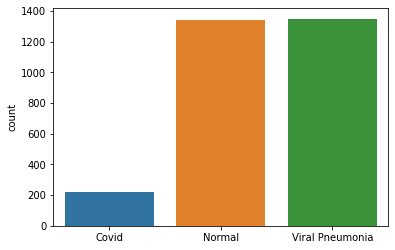

In [ ]:
l = []
for img in Y:
    l.append(labels[img])
sns.countplot(l);

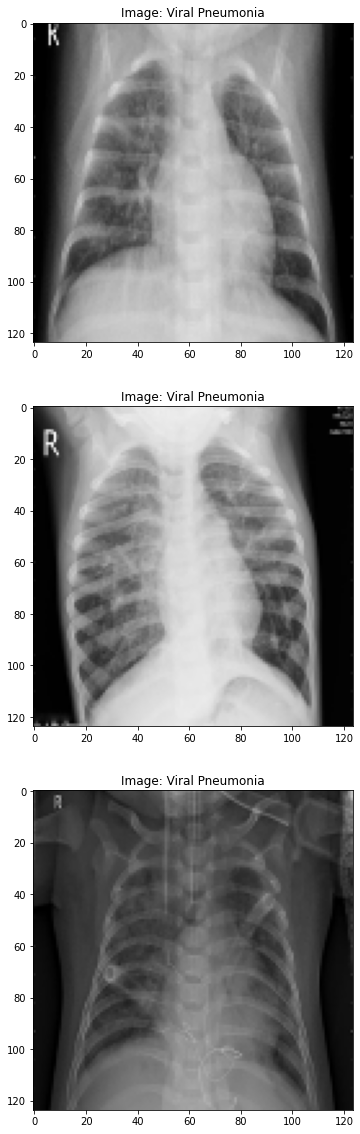

In [ ]:
fig, ax = plt.subplots(3)
fig.set_size_inches(15, 20)
for i in range(3):
        l = random.randint(0, len(X))
        ax[i].imshow(X[l])
        ax[i].set_title('Image: ' + labels[Y[l]])

## Preprocessing data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
# normalize the data
X = X / 255

# reshape the data
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y = Y.reshape(-1, 1)
Y = keras.utils.to_categorical(Y, 3)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

# Explore the dataset
print("X_train shape:" + str(X_train.shape))
print("Y_train shape:" + str(Y_train.shape))
print("X_test shape:" + str(X_test.shape))
print("Y_test shape:" + str(Y_test.shape))

X_train shape:(2037, 124, 124, 3)
Y_train shape:(2037, 3)
X_test shape:(873, 124, 124, 3)
Y_test shape:(873, 3)


# Modelling

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten,BatchNormalization
from keras.layers import Dense

In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
pre_trained_model = InceptionV3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet')

for layer in pre_trained_model.layers[:19]:
    layer.trainable = False

model1 = Sequential(
    [
        pre_trained_model,
        Flatten(),
        Dense(3, activation = 'softmax')
    ]
)

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 24579     
                                                                 
Total params: 21,827,363
Trainable params: 21,608,371
Non-trainable params: 218,992
_________________________________________________________________


In [ ]:
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history1 = model1.fit(X_train, Y_train, epochs = 100, validation_split = 0.2)

Epoch 1/100
51/51 [==============================] - 25s 321ms/step - loss: 0.5177 - accuracy: 0.8705 - val_loss: 15958.0146 - val_accuracy: 0.4681
Epoch 2/100
51/51 [==============================] - 15s 289ms/step - loss: 0.3328 - accuracy: 0.9153 - val_loss: 809.5123 - val_accuracy: 0.5147
Epoch 3/100
51/51 [==============================] - 15s 287ms/step - loss: 0.2592 - accuracy: 0.9380 - val_loss: 0.7587 - val_accuracy: 0.7745
Epoch 4/100
51/51 [==============================] - 15s 287ms/step - loss: 0.1029 - accuracy: 0.9650 - val_loss: 0.5292 - val_accuracy: 0.8775
Epoch 5/100
51/51 [==============================] - 15s 287ms/step - loss: 0.1428 - accuracy: 0.9693 - val_loss: 0.3057 - val_accuracy: 0.9020
Epoch 6/100
51/51 [==============================] - 15s 287ms/step - loss: 0.1719 - accuracy: 0.9552 - val_loss: 173.2675 - val_accuracy: 0.6912
Epoch 7/100
51/51 [==============================] - 15s 287ms/step - loss: 0.1458 - accuracy: 0.9613 - val_loss: 0.8113 - val_a

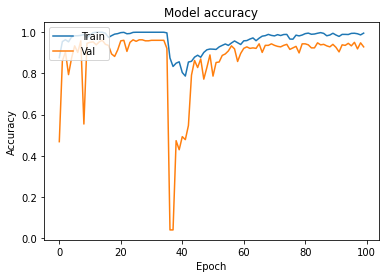

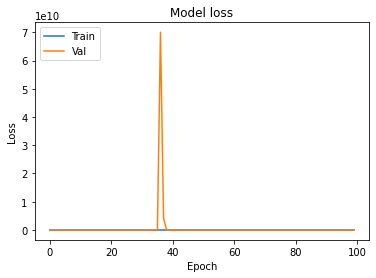

In [ ]:
# plot training and validation accuracy values
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

# plot training and validation loss values
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

In [ ]:
Y_pred = model1.predict(X_test)
Y_pred = np.argmax(Y_pred, axis = 1)
Y_test = np.argmax(Y_test, axis = 1)

# get the correctly and incorrectly labelled images
correct = np.nonzero(Y_pred == Y_test)[0]
incorrect = np.nonzero(Y_pred != Y_test)[0]

print("correct shape:" + str(correct.shape))
print("incorrect shape:" + str(incorrect.shape))

# Classification Report
print(classification_report(Y_test, Y_pred))

correct shape:(810,)
incorrect shape:(63,)
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        67
           1       0.96      0.91      0.93       415
           2       0.92      0.97      0.95       391

    accuracy                           0.93       873
   macro avg       0.89      0.88      0.89       873
weighted avg       0.93      0.93      0.93       873



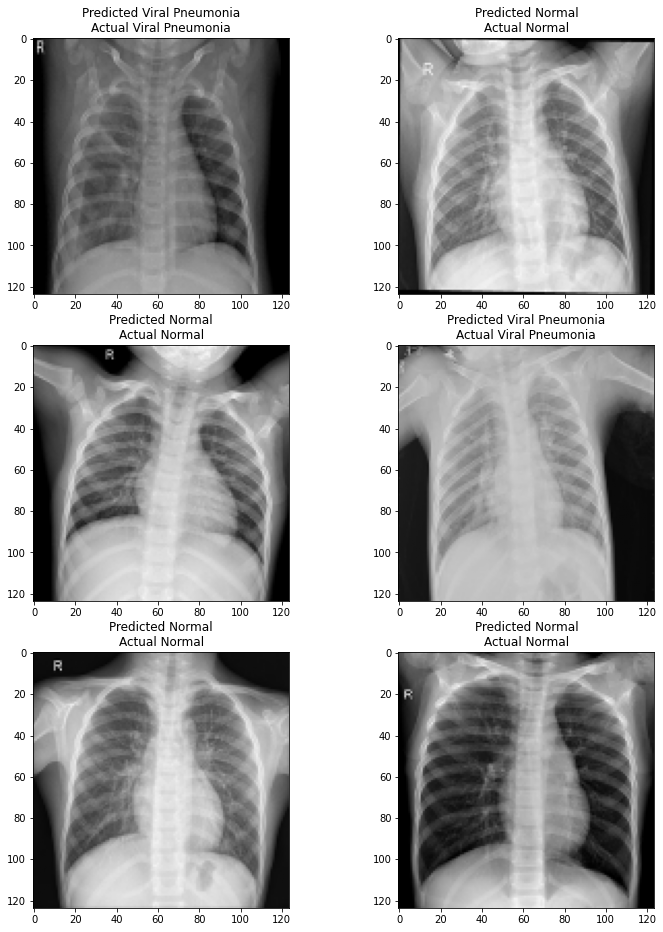

In [ ]:
# subset of correcly predicted images
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(12, 16)
cur = 0
for i in range(3):
    for j in range(2):
        ax[i, j].imshow(X_test[correct[cur]])
        ax[i, j].set_title("Predicted {}\nActual {}".format(labels[Y_pred[correct[cur]]], labels[Y_test[correct[cur]]]))
        cur = cur + 1

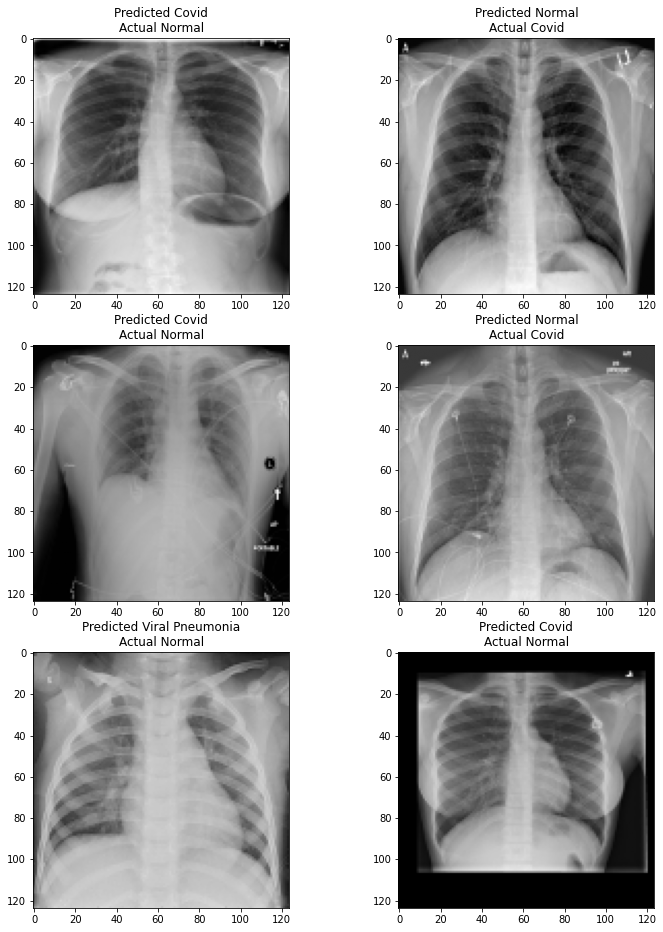

In [ ]:
# subset of incorrecly predicted images
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(12, 16)
cur = 0
for i in range(3):
    for j in range(2):
        ax[i, j].imshow(X_test[incorrect[cur]])
        ax[i, j].set_title("Predicted {}\nActual {}".format(labels[Y_pred[incorrect[cur]]], labels[Y_test[incorrect[cur]]]))
        cur = cur + 1

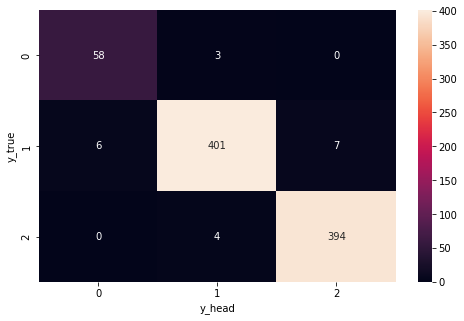

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

In [ ]:
#save model.h5
model1.save('model_inception_tkc.h5')

In [ ]:
!pip install pyyaml h5py
model_json = model1.to_json()
with open("model_inception_tkc.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("model_inception_tkc.hdf5")
print("Saved model to disk")

Saved model to disk


MODEL 		: model_inception_tkc.h5
PREDIKSI 	: Normal
PROBABILITAS 	: 1.0




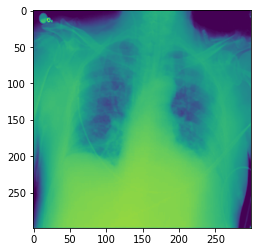

In [ ]:
#Prediksi citra meningioma
from PIL import Image
import cv2
from tensorflow.keras.models import  load_model

image = ["/content/drive/MyDrive/COVID-19_Radiography/dataset/Covid/COVID-1.png"]

model_list = ["/content/drive/MyDrive/COVID-19_Radiography/dataset/model_inception_tkc.h5"]
labels = ['Covid', 'Normal', 'Pneumonia']

for i in image :
  img_upload = Image.open(i)
  img = np.array(img_upload)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  for m in model_list:
      model = load_model(m)
      size_img = model.layers[0].output_shape[1:2]
      imgs = cv2.resize(img,(124, 124), interpolation = cv2.INTER_CUBIC)
      imgs = imgs.astype('float32') / 255
      pred = model.predict(np.expand_dims(imgs, axis=0))[0]
      print('MODEL \t\t:', m.split('/')[-1])
      print('PREDIKSI \t:',labels[((pred > 0.5)+0).ravel()[0]])
      print('PROBABILITAS \t:',[ round(elem, 4) for elem in pred ][0])
      print('\n')
      img_plt = plt.imshow(img_upload)

 #Disini didapat hasil pada model 1 dapat memprediksi benar citra meningioma dengan probabilitas 20,5 persen
 #Disini didapat hasil pada model 2 dapat memprediksi benar citra meningioma dengan probabilitas 24,4 persen

**Note : **

1. Jumlah Cell Classification Report 1 notebook hanya bisa 1 cell. Sehingga, jika dibutuhkan classification report dr model yg lain harus running dari awal. 
2. Berkaitan dengan poin 1, dipilih akurasi tertinggi dari ketiga model. Sehingga, yg ditampilkan Classification Report hanya untuk akurasi tertinggi "Model Ketiga dengan VGG16)